# INTRA BAR FEATURES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = pd.read_parquet("1M_EURUSD.parquet")

In [3]:
df

,Unnamed: 0,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,,
2020-01-02 03:00:00,1849364,1.12182,1.12183,1.12180,1.12182,12,5,0
2020-01-02 03:01:00,1849365,1.12182,1.12202,1.12182,1.12198,25,5,0
2020-01-02 03:02:00,1849366,1.12198,1.12204,1.12198,1.12204,18,5,0
2020-01-02 03:03:00,1849367,1.12204,1.12204,1.12201,1.12201,5,5,0
2020-01-02 03:04:00,1849368,1.12203,1.12214,1.12203,1.12214,15,5,0
...,...,...,...,...,...,...,...,...
2024-06-28 23:54:00,3519476,1.07124,1.07131,1.07121,1.07121,37,12,0
2024-06-28 23:55:00,3519477,1.07123,1.07129,1.07123,1.07125,27,12,0
2024-06-28 23:56:00,3519478,1.07125,1.07138,1.07125,1.07132,76,12,0


In [4]:
import pandas as pd
import numpy as np
from hurst import compute_Hc
from sklearn.linear_model import LinearRegression

# Function to calculate the Hurst exponent of a time series
def hurst_exponent(series):
    try:
        H, c, data = compute_Hc(series, kind='price')
    except:
        H = np.nan
    return H

# Function to calculate the percentage of closing prices between `low + start_percentage * (high - low)` and `low + end_percentage * (high - low)`
def close_percentage_in_range(series, low, high, start_percentage, end_percentage):
    start_threshold = low + start_percentage * (high - low)
    end_threshold = low + end_percentage * (high - low)
    count_in_range = series[(series >= start_threshold) & (series <= end_threshold)].count()
    total_count = series.count()
    return (count_in_range / total_count) * 100 if total_count > 0 else 0

# Aggregation function to calculate the percentage of closes within each 4-hour interval
def apply_close_percentage_in_range(df, start_percentage, end_percentage):
    low = df['low'].min()
    high = df['high'].max()
    close_prices = df['close']
    return close_percentage_in_range(close_prices, low, high, start_percentage, end_percentage)

# Function to calculate the slope of the linear regression
def linear_regression_slope(series):
    X = np.arange(len(series)).reshape(-1, 1)  # Create an array of indices for X
    y = series.values.reshape(-1, 1)  # Use the values of the series as y
    model = LinearRegression().fit(X, y)  # Fit the linear regression model
    slope = model.coef_[0][0]  # Extract the slope from the model
    return slope

# Aggregation function to apply linear regression to each 4-hour interval
def apply_linear_regression_slope(df):
    close_prices = df['close']
    try:
        coef = linear_regression_slope(close_prices)
    except:
        coef = 0
    return coef

# Aggregation function to apply linear regression to the last 25% of each 4-hour interval
def apply_linear_regression_slope_last_25(df):
    close_prices = df['close']
    num_points = max(2, int(len(close_prices) * 0.25))  # Ensure at least 2 points
    recent_prices = close_prices[-num_points:]  # Select the last 25% of the data
    try:
        coef = linear_regression_slope(recent_prices)
    except:
        coef = np.nan  # Handle any exceptions by returning NaN
    return coef


# Aggregate data into 4-hour intervals and add additional columns
data_4h = df.resample('4h').agg({
    'open': 'first',                  # First open price in the 4-hour interval
    'high': 'max',                    # Highest price in the 4-hour interval
    'low': 'min',                     # Lowest price in the 4-hour interval
    'close': 'last',                  # Last close price in the 4-hour interval
    'tick_volume': 'sum',             # Total tick volume in the 4-hour interval
})

# Calculate the Hurst exponent for each 4-hour interval
data_4h['hurst'] = df.resample('4h')['close'].apply(hurst_exponent)

# Calculate the percentage of closing prices within specified ranges for each 4-hour interval
data_4h['0_to_20'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.0, 0.2))
data_4h['20_to_40'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.2, 0.4))
data_4h['40_to_60'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.4, 0.6))
data_4h['60_to_80'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.6, 0.8))
data_4h['80_to_100'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.8, 1.0))

# Calculate the slope of the linear regression for each 4-hour interval
data_4h['linear_slope'] = df.resample('4h').apply(apply_linear_regression_slope)

data_4h['linear_slope_last_25'] = df.resample('4h').apply(apply_linear_regression_slope_last_25)

# Reset the index if necessary
data_4h.reset_index(inplace=True)

# Display the aggregated data for verification
print(data_4h)


                    time     open     high      low    close  tick_volume  \
0    2020-01-02 00:00:00  1.12182  1.12244  1.12180  1.12209         1116   
1    2020-01-02 04:00:00  1.12208  1.12244  1.12008  1.12043         3430   
2    2020-01-02 08:00:00  1.12042  1.12138  1.12011  1.12028         7633   
3    2020-01-02 12:00:00  1.12028  1.12037  1.11828  1.11962         8975   
4    2020-01-02 16:00:00  1.11960  1.12028  1.11634  1.11697        14699   
...                  ...      ...      ...      ...      ...          ...   
9835 2024-06-28 04:00:00  1.06973  1.06985  1.06850  1.06863         4254   
9836 2024-06-28 08:00:00  1.06863  1.07037  1.06857  1.06975         6685   
9837 2024-06-28 12:00:00  1.06976  1.07189  1.06916  1.07044         9123   
9838 2024-06-28 16:00:00  1.07043  1.07218  1.06922  1.07156        15375   
9839 2024-06-28 20:00:00  1.07156  1.07244  1.07058  1.07121         4996   

         hurst    0_to_20   20_to_40   40_to_60   60_to_80  80_to_100  \
0 

<AxesSubplot:xlabel='time'>

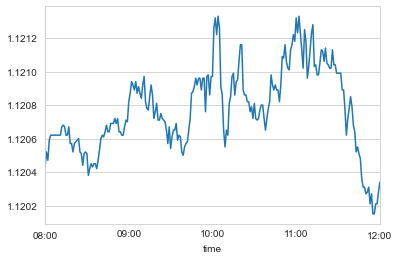

In [13]:
i = 2
df.loc[data_4h.loc[i,"time"]:data_4h.loc[i+1,"time"]]["close"].plot()

<AxesSubplot:>

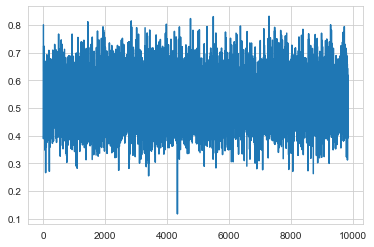

In [6]:
data_4h["hurst"].plot()

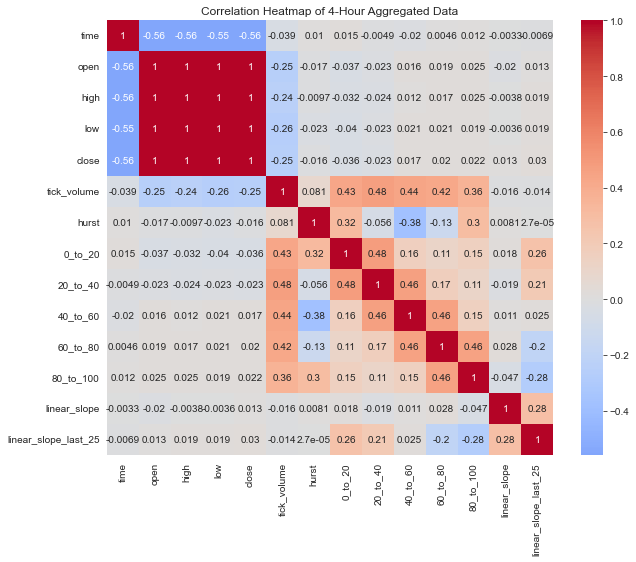

In [7]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_4h.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of 4-Hour Aggregated Data')
plt.show()

In [8]:
data_4h.head(15)

,time,open,high,low,close,tick_volume,hurst,0_to_20,20_to_40,40_to_60,60_to_80,80_to_100,linear_slope,linear_slope_last_25
0,2020-01-02 00:00:00,1.12182,1.12244,1.12180,1.12209,1116,NaN,10.000000,25.000000,13.333333,26.666667,25.000000,-0.000002,-7.500000e-06
1,2020-01-02 04:00:00,1.12208,1.12244,1.12008,1.12043,3430,0.800940,27.916667,5.416667,24.166667,13.750000,28.750000,-0.000010,2.794387e-06
2,2020-01-02 08:00:00,1.12042,1.12138,1.12011,1.12028,7633,0.389531,5.416667,17.916667,40.416667,25.833333,10.416667,0.000001,-1.903973e-05
3,2020-01-02 12:00:00,1.12028,1.12037,1.11828,1.11962,8975,0.536219,4.583333,21.666667,46.666667,14.166667,12.916667,-0.000003,2.444290e-06
4,2020-01-02 16:00:00,1.11960,1.12028,1.11634,1.11697,14699,0.578861,27.916667,32.916667,27.083333,6.666667,5.416667,-0.000006,9.637955e-06
5,2020-01-02 20:00:00,1.11697,1.11733,1.11635,1.11723,5570,0.401566,7.531381,15.899582,28.033473,30.125523,18.410042,0.000002,2.108124e-06
6,2020-01-03 00:00:00,1.11709,1.11783,1.11680,1.11733,2902,0.551425,6.808511,32.340426,36.595745,16.595745,7.659574,0.000002,-5.483712e-06
7,2020-01-03 04:00:00,1.11733,1.11773,1.11643,1.11662,5783,0.554931,6.666667,15.416667,24.583333,36.666667,17.500000,-0.000003,9.066407e-07
8,2020-01-03 08:00:00,1.11662,1.11714,1.11399,1.11400,10596,0.599449,14.583333,15.833333,32.083333,10.416667,28.333333,-0.000011,-1.461962e-05
9,2020-01-03 12:00:00,1.11400,1.11486,1.11248,1.11381,10893,0.563681,17.916667,33.333333,17.916667,15.833333,15.000000,0.000005,-4.817171e-06


In [127]:
data_4h.dropna(thresh=data_4h.shape[1]-2).reset_index(drop=True).to_parquet(f"4H_EURUSD.parquet",compression='gzip') 